In [1]:
WANDB_API_KEY="e4732f42369bbff1fe2c1194b4221d194945e03a"

In [3]:
import warnings
import math
import wandb
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from collections import defaultdict
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.vector_ar.vecm import coint_johansen

pd.options.display.max_rows = 500
warnings.filterwarnings('ignore')

In [4]:
def plot_features(df, cols, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    df.plot(ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    plt.legend(cols)
    plt.axhline(0, linestyle='--', color='k', alpha=0.3)
    plt.show()

In [5]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sagar118. Use `wandb login --relogin` to force relogin


True

In [6]:
# Read the datasets
data = pd.read_csv("../data/train.csv")
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [7]:
# Concatecate `StateCode` and `StationId` with '-' as separator
data["StateStation"] = data["StateCode"] + "_" + data["StationId"].astype(str)
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
data["month_year"] = data["Date"].apply(lambda x: dt.datetime.strftime(x, "%Y-%m"))

In [8]:
data.head()

,ID_Date,StateCode,StationId,Date,PM2.5,PM10,O3,CO,SO2,AQI,StateStation,month_year
0,AS_4_2021-08-17,AS,4,2021-08-17,51.8364,120.3702,18.0234,0.4896,14.3106,94.0,AS_4,2021-08
1,AS_4_2021-08-18,AS,4,2021-08-18,59.4762,87.0978,34.5270,0.4794,14.7594,124.0,AS_4,2021-08
2,AS_4_2021-08-19,AS,4,2021-08-19,61.0776,79.6008,42.0546,0.5202,16.7484,82.0,AS_4,2021-08
3,AS_4_2021-08-20,AS,4,2021-08-20,56.7222,94.2072,45.7878,0.4998,27.6114,107.0,AS_4,2021-08
4,AS_4_2021-08-21,AS,4,2021-08-21,85.3332,136.7820,44.5638,1.1118,26.4180,107.0,AS_4,2021-08


In [8]:
# Create a W&B Run. Here we specify 'dataset' as the job type since this example
# shows how to create a dataset artifact.
run = wandb.init(project="H2O-hackathon", job_type="upload-raw-dataset", name="upload-raw-dataset")
# Create Artifact object
artifact = wandb.Artifact(name='dataset', type='dataset')

In [9]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=data)
# Add a file to the artifact's contents
artifact.add(table, name='train')
# Save the artifact version to W&B and mark it as the output of this run
run.log_artifact(artifact)

In [10]:
wandb.finish()

In [9]:
aqi = defaultdict(lambda: pd.DataFrame())
for code in data.StateStation.unique():
    aqi[code] = data[data.StateStation == code][['Date', 'PM2.5', 'PM10', 'O3', 'SO2', 'AQI']]
    aqi[code].reset_index(drop=True, inplace=True)
    aqi[code].sort_values(by=['Date'], inplace=True)

In [68]:
aqi.keys()

dict_keys(['AS_4', 'DL_4', 'DL_6', 'DL_8', 'DL_12', 'DL_13', 'DL_18', 'DL_19', 'DL_21', 'DL_23', 'DL_25', 'DL_26', 'DL_27', 'DL_29', 'DL_30', 'DL_32', 'DL_35', 'DL_38', 'DL_39', 'DL_40', 'DL_41', 'KA_7', 'KA_9', 'KA_10', 'KA_11', 'KA_14', 'MH_10', 'MH_11', 'MH_12', 'MH_13', 'MH_14', 'MH_15', 'MH_16', 'MH_17', 'TN_5', 'TN_8', 'WB_12', 'WB_13', 'WB_14', 'WB_16'])

## Re-run starts here

In [1656]:
state_station = 'WB_16'

In [1657]:
aqi[state_station].head()

,Date,PM2.5,PM10,O3,SO2,AQI
0,2020-10-11,29.00,50.87,30.99,10.32,73.0
1,2020-10-12,21.70,43.04,43.72,10.32,60.0
2,2020-10-13,23.09,46.49,41.65,10.32,74.0
3,2020-10-14,21.56,42.10,44.07,10.32,83.0
4,2020-10-15,30.28,54.89,63.88,10.32,95.0


In [1658]:
df = aqi[state_station].set_index('Date')
df.head()

,PM2.5,PM10,O3,SO2,AQI
Date,,,,,
2020-10-11,29.00,50.87,30.99,10.32,73.0
2020-10-12,21.70,43.04,43.72,10.32,60.0
2020-10-13,23.09,46.49,41.65,10.32,74.0
2020-10-14,21.56,42.10,44.07,10.32,83.0
2020-10-15,30.28,54.89,63.88,10.32,95.0


In [1659]:
df.dropna(inplace=True)

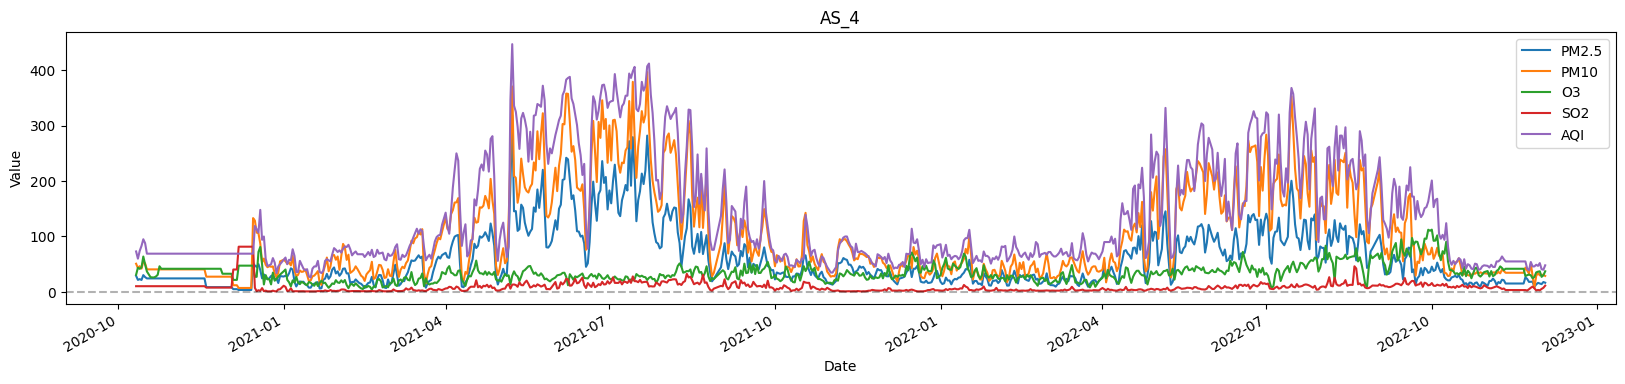

In [1660]:
plot_features(df, ['PM2.5', 'PM10', 'O3', 'SO2', 'AQI'], 'AS_4')

In [1661]:
# Create a W&B Run. Here we specify 'dataset' as the job type since this example
# shows how to create a dataset artifact.
run = wandb.init(project="H2O-hackathon", job_type="upload-stats", name=f"{state_station}-stats")
# Create Artifact object
artifact = wandb.Artifact(name=f'{state_station}-Stats', type='stats')

## Testing Causation using Granger's Causality Test

In [1662]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    df['-'] = [var + '_y' for var in variables]
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    # print(cols)
    df = df[cols]
    return df

grangers_maxtrix = grangers_causation_matrix(df, variables = df.columns) 
grangers_maxtrix

,-,PM2.5_x,PM10_x,O3_x,SO2_x,AQI_x
PM2.5_y,PM2.5_y,1.0000,0.0001,0.2647,0.4231,0.0000
PM10_y,PM10_y,0.0080,1.0000,0.1402,0.0736,0.0004
O3_y,O3_y,0.1487,0.2444,1.0000,0.0061,0.0129
SO2_y,SO2_y,0.0171,0.0031,0.0060,1.0000,0.0695
AQI_y,AQI_y,0.0000,0.0000,0.1286,0.1025,1.0000


In [1663]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=grangers_maxtrix)
# Add a file to the artifact's contents
artifact.add(table, name='grangers_causation_matrix')

ArtifactManifestEntry(path='grangers_causation_matrix.table.json', digest='V4mQmh7tLIR9Gw1H3HRnhQ==', ref=None, birth_artifact_id=None, size=1050, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmpuz82dj5o')

## Cointegration Test

In [1664]:
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    out = {'Test Stat': traces, 'C(95%)': cvts}
    res = pd.DataFrame.from_dict(out)
    res['Signif'] = res['Test Stat'] > res['C(95%)']
    res['Columns'] = df.columns
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
    cols = res.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    res = res[cols]
    return res

cointegration_df = cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
PM2.5  ::  159.01    > 60.0627   =>   True
PM10   ::  87.88     > 40.1749   =>   True
O3     ::  43.75     > 24.2761   =>   True
SO2    ::  12.83     > 12.3212   =>   True
AQI    ::  1.87      > 4.1296    =>   False


In [1665]:
cointegration_df

,Columns,Test Stat,C(95%),Signif
0,PM2.5,159.013712,60.0627,True
1,PM10,87.879340,40.1749,True
2,O3,43.748164,24.2761,True
3,SO2,12.832294,12.3212,True
4,AQI,1.868867,4.1296,False


In [1666]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=cointegration_df)
# Add a file to the artifact's contents
artifact.add(table, name='cointegration_test')

ArtifactManifestEntry(path='cointegration_test.table.json', digest='7kGY9v1aggA2i9vlHAgM8A==', ref=None, birth_artifact_id=None, size=830, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmpu5greguq')

## Split the Series into Training and Testing Data

In [1667]:
nobs = 28
# df_train, df_test = df[['PM2.5', 'PM10', 'AQI']][0:-nobs], df[['PM2.5', 'PM10', 'AQI']][-nobs:]
df_train = df[['PM2.5', 'PM10', 'AQI']].copy()
# df_train = df[['PM2.5', 'PM10', 'SO2', 'AQI']].copy()
# df_train = df[['PM2.5', 'PM10', 'O3', 'AQI']].copy()
# df_train = df[['PM2.5', 'PM10', 'O3', 'SO2', 'AQI']].copy()
# Check size
print(df_train.shape)  # (436, 5)
# print(df_test.shape)  # (28, 5)

(770, 3)


## Check for Stationarity and Make the Time Series Stationary

In [1668]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'signif': signif, 'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')
        output[f' Critical value {adjust(key)}'] = round(val, 3)
    output['Column'] = name
    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")
    res = pd.DataFrame(output, index=[name])
    # res.columns = ['Value']
    return res

In [1669]:
res = pd.DataFrame()
for name, column in df_train.iteritems():
    out = adfuller_test(column, name=column.name)
    res = pd.concat([res, out])
    print('\n')

    Augmented Dickey-Fuller Test on "PM2.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5136
 No. Lags Chosen       = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.5268. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "PM10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.339
 No. Lags Chosen       = 19
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.6112. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "AQI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit r

In [1670]:
res

,signif,test_statistic,pvalue,n_lags,n_obs,Critical value 1%,Critical value 5%,Critical value 10%,Column
PM2.5,0.05,-1.5136,0.5268,19,750,-3.439,-2.865,-2.569,PM2.5
PM10,0.05,-1.3390,0.6112,19,750,-3.439,-2.865,-2.569,PM10
AQI,0.05,-1.5107,0.5282,15,754,-3.439,-2.865,-2.569,AQI


In [1671]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=res)
# Add a file to the artifact's contents
artifact.add(table, name='check_stationary')

ArtifactManifestEntry(path='check_stationary.table.json', digest='ZWpS56DPrZYD6Mz2HrkoAg==', ref=None, birth_artifact_id=None, size=1493, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmpapg4_chw')

In [1672]:
# df_differenced = df_train.copy()

In [1673]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [1674]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "PM2.5" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.0269
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "PM10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.1884
 No. Lags Chosen       = 20
 Critical value 1%     = -3.439
 Critical value 5%     = -2.865
 Critical value 10%    = -2.569
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "AQI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

## How to Select the Order (P) of VAR model

In [1675]:
# df_differenced_new = df_differenced[['PM2.5', 'PM10', 'AQI']]

In [1676]:
model = VAR(df_differenced)
aic_scores = pd.DataFrame()
AIC = []
BIC = []
FPE = []
HQIC = []
for i in [1,2,3,4,5,6,7,8,9,10,11,12]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    AIC.append(result.aic)
    BIC.append(result.bic)
    FPE.append(result.fpe)
    HQIC.append(result.hqic)
aic_scores['AIC'] = AIC
aic_scores['BIC'] = BIC
aic_scores['FPE'] = FPE
aic_scores['HQIC'] = HQIC

Lag Order = 1
AIC :  17.202546837131106
BIC :  17.27510605171154
FPE :  29578169.186555758
HQIC:  17.230474416619245 

Lag Order = 2
AIC :  17.11598236329114
BIC :  17.24309086763105
FPE :  27125475.067959275
HQIC:  17.16490860747548 

Lag Order = 3
AIC :  17.03266587731982
BIC :  17.21443541399373
FPE :  24957135.408900946
HQIC:  17.102636372248256 

Lag Order = 4
AIC :  16.96891864634724
BIC :  17.20546133591487
FPE :  23415961.489265822
HQIC:  17.05997913596804 

Lag Order = 5
AIC :  16.942554326820858
BIC :  17.23398266959572
FPE :  22806877.694101878
HQIC:  17.05475071373022 

Lag Order = 6
AIC :  16.935649943946707
BIC :  17.2820768217753
FPE :  22650236.204159323
HQIC:  17.069028290140864 

Lag Order = 7
AIC :  16.92317220058903
BIC :  17.32471087864063
FPE :  22369754.44860029
HQIC:  17.07777872822083 

Lag Order = 8
AIC :  16.923029105269546
BIC :  17.37979323383673
FPE :  22367063.59083678
HQIC:  17.098910197409616 

Lag Order = 9
AIC :  16.88438257609728
BIC :  17.3964861924

In [1677]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=aic_scores)
# Add a file to the artifact's contents
artifact.add(table, name='p_values(lag_order)')

ArtifactManifestEntry(path='p_values(lag_order).table.json', digest='LmaTPazJOKqPEMatM7a9wQ==', ref=None, birth_artifact_id=None, size=1534, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmpe_19a_a7')

In [1678]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,17.68,17.70,4.775e+07,17.69
1,17.24,17.32,3.081e+07,17.27
2,17.15,17.28,2.816e+07,17.20
3,17.07,17.25,2.583e+07,17.14
4,17.00,17.24*,2.416e+07,17.09
5,16.97,17.26,2.345e+07,17.08*
6,16.96,17.31,2.321e+07,17.09
7,16.94,17.35,2.284e+07,17.10
8,16.94,17.40,2.274e+07,17.12
9,16.90,17.41,2.179e+07,17.09


In [1679]:
model_fitted = model.fit(11)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 12, Apr, 2023
Time:                     17:16:50
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    17.5119
Nobs:                     758.000    HQIC:                   17.1287
Log likelihood:          -9525.50    FPE:                2.16153e+07
AIC:                      16.8887    Det(Omega_mle):     1.89493e+07
--------------------------------------------------------------------
Results for equation PM2.5
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const            -0.037913         0.728373           -0.052           0.958
L1.PM2.5         -0.424052         0.106394           -3.986           0.000
L1.PM10           0.266080         0.068096            3.907           0.000

In [1680]:
model_fitted.save(f'models/VAR_{state_station}.pkl')

## Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [1681]:
out = durbin_watson(model_fitted.resid)
def adjust(val, length= 6): return str(val).ljust(length)

for col, val in zip(df_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

PM2.5  : 2.01
PM10   : 2.01
AQI    : 2.0


In [1682]:
result = pd.Series(out, index=df_differenced.columns).to_frame()
result = result.T

In [1683]:
result

,PM2.5,PM10,AQI
0,2.00767,2.005641,1.997049


In [1684]:
# Create a wandb.Table from the pandas DataFrame
table = wandb.Table(dataframe=result)
# Add a file to the artifact's contents
artifact.add(table, name='durbin_watson_test')

ArtifactManifestEntry(path='durbin_watson_test.table.json', digest='qTmcQHET1JxxnpFaxsyndw==', ref=None, birth_artifact_id=None, size=532, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmp2f0xuemz')

In [1685]:
# Add a file to the artifact's contents
artifact.add_file(f'models/VAR_{state_station}.pkl')

ArtifactManifestEntry(path='VAR_WB_16.pkl', digest='SPX11TeKWVJHRKZts9Mnjw==', ref=None, birth_artifact_id=None, size=313245, extra={}, local_path='/Users/wizard/Library/Application Support/wandb/artifacts/staging/tmpajmqvbrt')

In [1686]:
# Save the artifact version to W&B and mark it as the output of this run
run.log_artifact(artifact)

In [1687]:
wandb.finish()

## How to Forecast VAR model using statsmodels

In [1688]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

11


array([[ -2.961 ,  -5.1975, -13.    ],
       [ -5.313 ,  -5.5335,  -3.    ],
       [  0.21  ,  17.871 ,  15.    ],
       [  0.1995, -22.281 ,  -8.    ],
       [ -9.471 , -21.966 ,   0.    ],
       [  4.536 ,  22.218 ,   3.    ],
       [  2.793 ,   4.9035,  -2.    ],
       [ -1.0395,  -3.9795,   5.    ],
       [ -1.1865,   1.218 , -11.    ],
       [  3.759 ,  -0.5985,  -1.    ],
       [ -1.239 ,  -1.659 ,   8.    ]])

In [1689]:
# start date
start_date = datetime.strptime("2022-12-04", "%Y-%m-%d")
end_date = datetime.strptime("2022-12-31", "%Y-%m-%d")

# difference between each date. D means one day
D = 'D'

date_list = pd.date_range(start_date, end_date, freq=D)
date_list

DatetimeIndex(['2022-12-04', '2022-12-05', '2022-12-06', '2022-12-07',
               '2022-12-08', '2022-12-09', '2022-12-10', '2022-12-11',
               '2022-12-12', '2022-12-13', '2022-12-14', '2022-12-15',
               '2022-12-16', '2022-12-17', '2022-12-18', '2022-12-19',
               '2022-12-20', '2022-12-21', '2022-12-22', '2022-12-23',
               '2022-12-24', '2022-12-25', '2022-12-26', '2022-12-27',
               '2022-12-28', '2022-12-29', '2022-12-30', '2022-12-31'],
              dtype='datetime64[ns]', freq='D')

In [1690]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
# df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_test.columns + '_1d')
df_forecast = pd.DataFrame(fc, index=date_list, columns=df_train.columns + '_1d')
df_forecast

,PM2.5_1d,PM10_1d,AQI_1d
2022-12-04,5.797930,8.083016,3.985812
2022-12-05,-4.326671,-1.562778,-0.082124
2022-12-06,-2.064531,-3.400080,0.277536
2022-12-07,2.787419,1.881631,-0.975776
2022-12-08,-3.624681,-4.050296,-2.965522
2022-12-09,0.626439,-0.557894,-2.088611
2022-12-10,1.432979,1.949598,1.219979
2022-12-11,-0.815998,-0.365681,1.222583
2022-12-12,0.997853,1.478662,0.088937
2022-12-13,-0.930388,-0.941257,-1.134197


## Invert the transformation to get the real forecast

In [1691]:
def invert_transformation(df_train, df_forecast, second_diff=False, any_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    if any_diff:
        df_fc = df_forecast.copy()
        columns = df_train.columns
        for col in columns:        
            # Roll back 2nd Diff
            if second_diff:
                df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
            # Roll back 1st Diff
            df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
        return df_fc
    else:
        df_fc = df_forecast.copy()
        df_fc.rename(columns={'AQI_1d': 'AQI_forecast'}, inplace=True)
        return df_fc

In [1692]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False, any_diff=True)        
# df_results = invert_transformation(df_train, df_forecast, second_diff=False, any_diff=False)        
# df_results.loc[:, ['PM2.5', 'PM10', 'AQI']]

In [1693]:
df_results

,PM2.5_1d,PM10_1d,AQI_1d,PM2.5_forecast,PM10_forecast,AQI_forecast
2022-12-04,5.797930,8.083016,3.985812,22.419430,36.958016,51.985812
2022-12-05,-4.326671,-1.562778,-0.082124,18.092758,35.395237,51.903688
2022-12-06,-2.064531,-3.400080,0.277536,16.028227,31.995157,52.181224
2022-12-07,2.787419,1.881631,-0.975776,18.815646,33.876787,51.205448
2022-12-08,-3.624681,-4.050296,-2.965522,15.190965,29.826492,48.239926
2022-12-09,0.626439,-0.557894,-2.088611,15.817403,29.268598,46.151315
2022-12-10,1.432979,1.949598,1.219979,17.250382,31.218197,47.371294
2022-12-11,-0.815998,-0.365681,1.222583,16.434384,30.852516,48.593877
2022-12-12,0.997853,1.478662,0.088937,17.432237,32.331178,48.682814
2022-12-13,-0.930388,-0.941257,-1.134197,16.501849,31.389920,47.548617


In [1694]:
temp = df_results.reset_index()
temp = temp.rename(columns={'index': 'ID_Date', 'AQI_forecast': 'AQI'})
temp['ID_Date'] = temp['ID_Date'].dt.strftime('%Y-%m-%d')
temp['ID_Date'] = temp['ID_Date'].map(lambda x: f'{state_station}_{x}')
temp = temp[['ID_Date', 'AQI']]
submission = pd.concat([submission, temp])

In [1695]:
submission.tail()

,ID_Date,AQI
23,WB_16_2022-12-27,47.856663
24,WB_16_2022-12-28,47.529171
25,WB_16_2022-12-29,47.532770
26,WB_16_2022-12-30,47.622945
27,WB_16_2022-12-31,47.750781


In [1696]:
submission.shape

(1120, 2)

In [1697]:
submission.to_csv("./submissions/tmp_submission.csv", index=False)

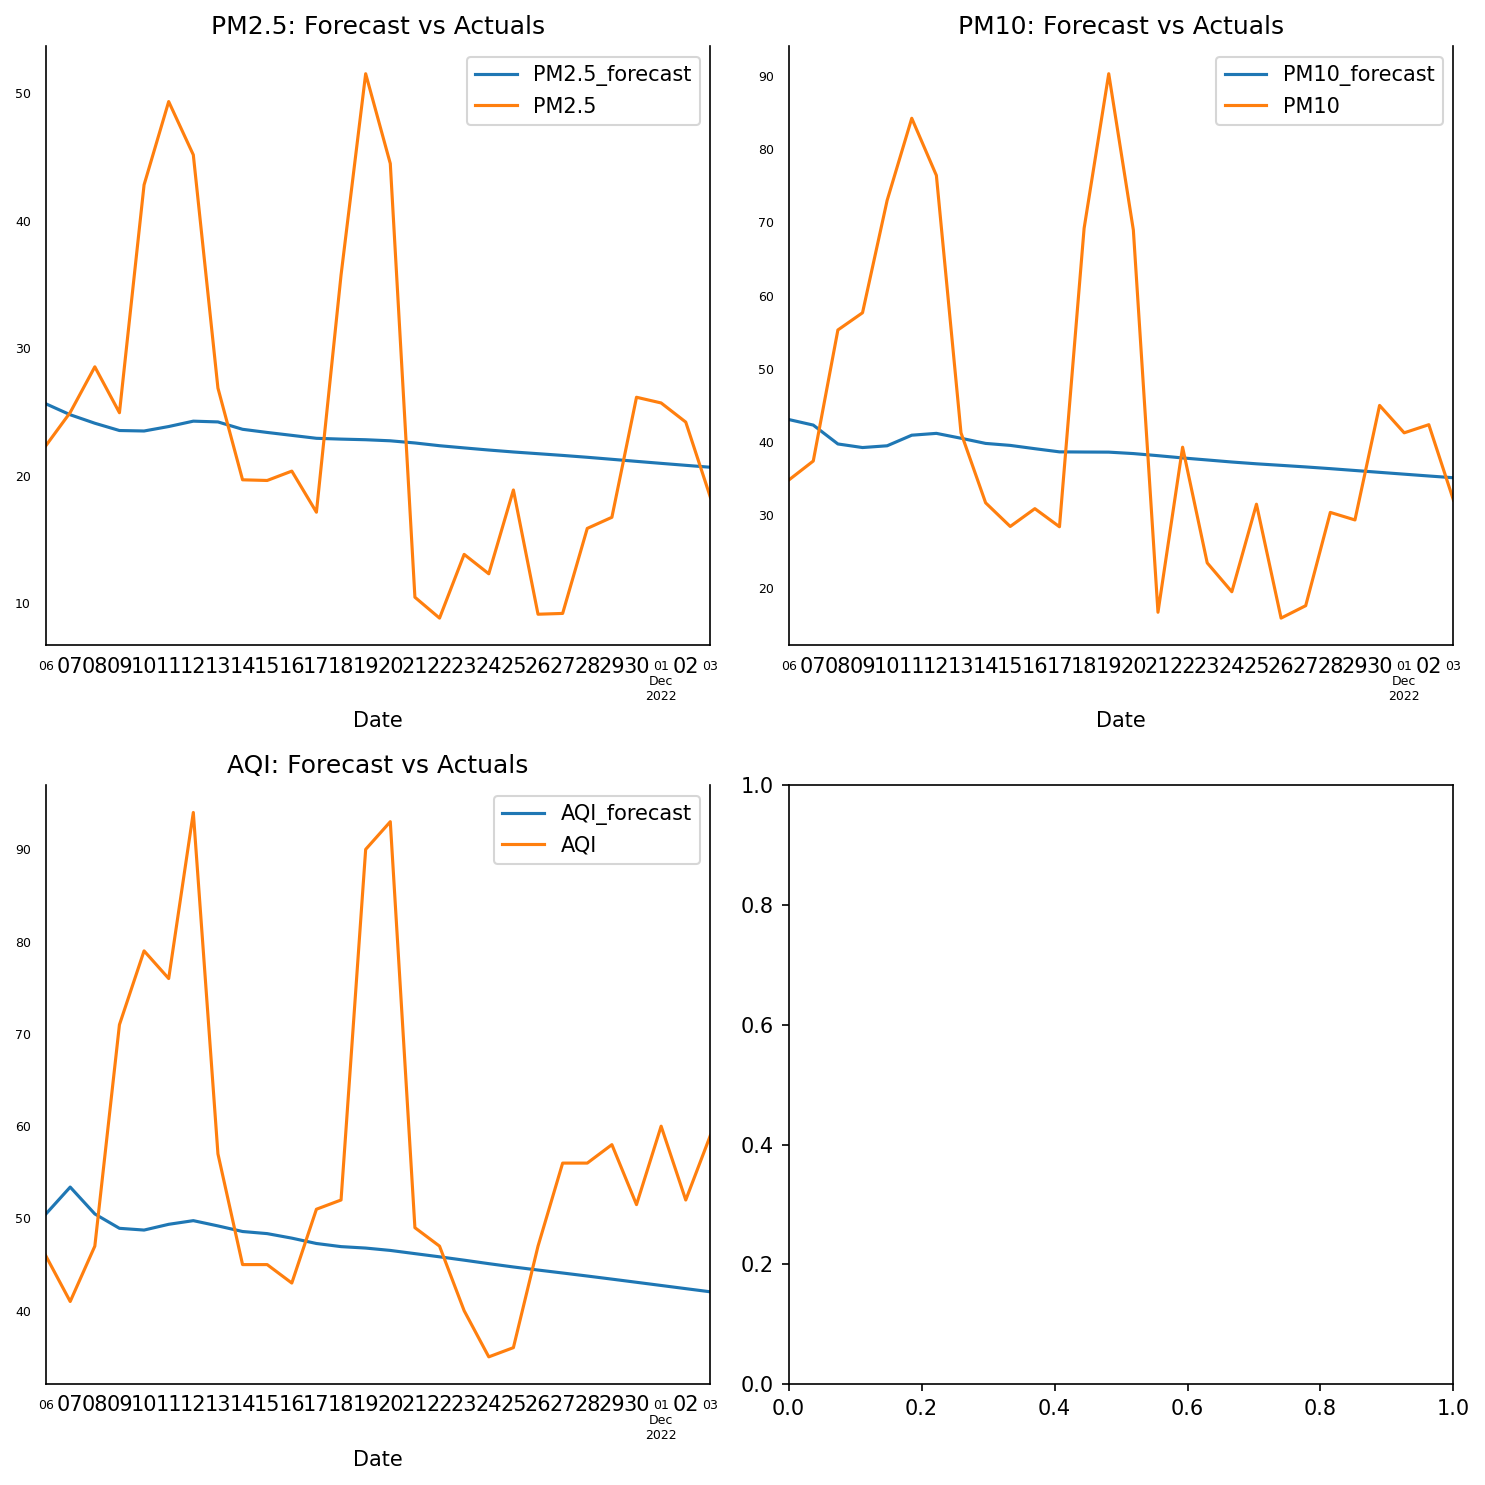

In [111]:
fig, axes = plt.subplots(nrows=math.ceil(len(df_test.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_test.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [113]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    mmae = np.mean(np.abs(actual - forecast) * np.where(actual > forecast, 1.5, 1))
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax, 'mmae':mmae})

print('Forecast Accuracy of: PM2.5')
accuracy_prod = forecast_accuracy(df_results['PM2.5_forecast'].values, df_test['PM2.5'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: PM10')
accuracy_prod = forecast_accuracy(df_results['PM10_forecast'].values, df_test['PM10'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

print('\nForecast Accuracy of: AQI')
accuracy_prod = forecast_accuracy(df_results['AQI_forecast'].values, df_test['AQI'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: PM2.5
mape   :  0.4426
me     :  -1.6795
mae    :  9.0911
mpe    :  0.1806
rmse   :  11.8952
corr   :  0.3775
minmax :  0.2976
mmae   :  11.7838

Forecast Accuracy of: PM10
mape   :  0.4134
me     :  -4.2073
mae    :  16.0076
mpe    :  0.1237
rmse   :  20.5986
corr   :  0.3515
minmax :  0.3004
mmae   :  21.0614

Forecast Accuracy of: AQI
mape   :  0.2126
me     :  -9.6606
mae    :  13.694
mpe    :  -0.112
rmse   :  18.8088
corr   :  0.1105
minmax :  0.2042
mmae   :  19.5327


<Axes: >

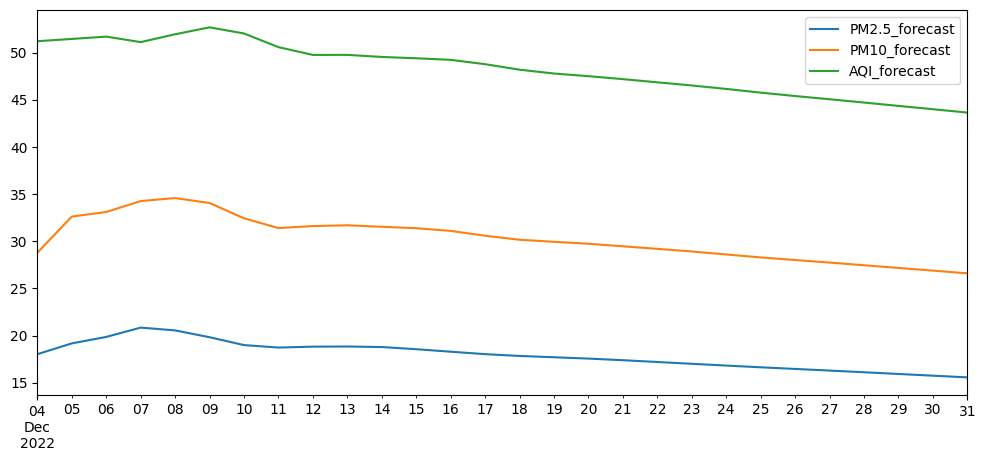

In [143]:
df_results[['PM2.5_forecast', 'PM10_forecast', 'AQI_forecast']].plot(figsize=(12,5))

In [57]:
submission = pd.DataFrame(columns=['ID_Date', 'AQI'])

In [58]:
submission.head()

,ID_Date,AQI
